In [1]:
from argparse import ArgumentParser
from cpo import CPO
from memory import Memory
from models import build_diag_gauss_policy, build_mlp, Actor, Critic
# from simulators import SinglePathSimulator
import pandas as pd
import numpy as np

from data_util import read_file
# from fair_env_simulator import *
from fair_env import *
import torch
import os
import time
import torch.nn.functional as F
from gini import gini
import matplotlib.pyplot as plt
from test_ranking import *

In [2]:
model_name = 'fairrec'
data_name = 'ml-1m'
data = read_file('../data/'+data_name+'/train_data.csv')
item_embeddings = np.load('../data/'+data_name+'/item_embed.npy')
user_embeddings = np.load('../data/'+data_name+'/user_embed.npy')
item_indicator = np.load('../data/'+data_name+'/item_cost_indicator_28.npy')

nb_item = item_embeddings.shape[0]
nb_user = user_embeddings.shape[0]
print('num of users: %d, num of items: %d' %(nb_user, nb_item))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env_args = {}
env_args['data'] = data
env_args['nb_user'] = nb_user
env_args['nb_item'] = nb_item
env_args['item_embeddings'] = item_embeddings
env_args['user_embeddings'] = user_embeddings
env_args['item_indicator'] = item_indicator
env_args['device'] = device
env_args['gamma'] = 0.95
env_args['frac'] = 1

env = Environment(**env_args)
print('Successfully create Training Env!')

num of users: 6040, num of items: 3706
Successfully create Training Env!


In [5]:
from collections import defaultdict, namedtuple
import numpy as np
import torch

from autoassign import autoassign
from memory import Memory, Trajectory
from torch_utils.torch_utils import get_device
from gini import gini


class Simulator:
    def __init__(self, env, policy, n_trajectories, trajectory_len, **env_args):
        self.env = env
        self.policy = policy


class SinglePathSimulator(Simulator):
    def __init__(self, env, policy, n_trajectories, trajectory_len, **env_args):
        Simulator.__init__(self, env, policy, n_trajectories, trajectory_len, **env_args)
        self.item_embeddings= env_args['item_embeddings']
        self.trajectory_len = trajectory_len
        self.n_trajectories = n_trajectories
        self.nb_item = env_args['nb_item']
        self.device = env_args['device']
        self.hit_rate = []
        self.gini_coefficient = []
        self.pop_rate = []

    def run_sim(self):
        self.policy.eval()
        with torch.no_grad():
            trajectories = np.asarray([Trajectory() for i in range(self.n_trajectories)])

            ra_length = 1
#             epsilon = 0.9
            item_embeds = torch.from_numpy(self.item_embeddings).to(self.device).float()

            ave_score = 0
            ave_cost = 0
            states = self.env.reset()
#             print(states.shape)
#             input()
            recommended_item_onehot = torch.FloatTensor(self.n_trajectories, self.nb_item).zero_().to(self.device)
            recommendations = []
            for t in range(self.trajectory_len): 
                policy_input = torch.FloatTensor(states).to(self.device).view(self.n_trajectories, -1)
                weight_dists = self.policy(policy_input)
                w = weight_dists.sample()
#                 print(w.shape)
#                 input()
                item_weights = torch.mm(w.view(-1,item_embeds.shape[1]), item_embeds.transpose(0,1)).view(self.n_trajectories, ra_length, -1)
                item_weights = torch.mul(item_weights.transpose(0,1), 1-recommended_item_onehot).reshape(states.shape[0],ra_length,-1)
                item_idxes = torch.argmax(item_weights,dim=2)

                recommendations.append(item_idxes)
                recommended_item_onehot = recommended_item_onehot.scatter_(1, item_idxes, 1)

                actions = item_embeds[item_idxes.cpu().detach()]
                states_prime, rewards, costs, info = self.env.step(actions, item_idxes)

                for i in range(len(trajectories)):
                    trajectory = trajectories[i]
                    trajectory.observations.append(policy_input[i].to(self.device).squeeze())
                    trajectory.actions.append(actions[i].to(self.device).squeeze())
                    trajectory.rewards.append(rewards[i].to(self.device).squeeze())
                    trajectory.costs.append(costs[i].to(self.device).squeeze())

               
                states = states_prime
                ave_score += torch.sum(info).detach().cpu()
                ave_cost += torch.sum(costs).detach().cpu()
                 
            memory = Memory(trajectories)
    
#             print(ave_score.float()/(self.trajectory_len*self.n_trajectories), ave_cost/(self.trajectory_len*self.n_trajectories))
            self.pop_rate.append(ave_cost/(self.trajectory_len*self.n_trajectories))

            recommendation_tensor = torch.cat(recommendations,1)
            idx, val = torch.unique(torch.cat(recommendations), return_counts=True)
#             hr = (ave_score.float()/(self.trajectory_len*self.n_trajectories)).cpu().numpy()
#             self.hit_rate.append(hr)
            
            val_ = torch.cat((val.float(),torch.zeros(self.nb_item-len(val)).to(self.device)))
            g = gini(val_.cpu().numpy())
            self.gini_coefficient.append(g)
            
            return memory

In [10]:
history_length = 5 # N in article
ra_length = 1 # K in article
state_space_size = item_embeddings.shape[1] * history_length
action_space_size = item_embeddings.shape[1] * ra_length


vf_hidden_dims = [256,64]
vf_args = (state_space_size + 1, vf_hidden_dims, 1)
value_fun = build_mlp(*vf_args)

cost_fun = build_mlp(*vf_args)

policy_hidden_dims = [256,64]
policy_args = (state_space_size, policy_hidden_dims, action_space_size)
policy = build_diag_gauss_policy(*policy_args)

policy.to(device)
value_fun.to(device)
cost_fun.to(device)
# print(policy)
# print(value_fun)
# print(cost_fun)

n_trajectories = env.nb_user
trajectory_len = 10
simulator = SinglePathSimulator(env, policy, n_trajectories, trajectory_len, **env_args)

max_constraint_val = 100
cpo = CPO(policy, value_fun, cost_fun, simulator, device, model_name=model_name, max_constraint_val=max_constraint_val, continue_from_file=False)
n_episodes = 150
cpo.train(n_episodes)

Step Len.: 0.9
[Episode]: 1 | [Avg. Reward]: 0.35711920261383057 | [Avg. Cost]: 1.6291390657424927 | [Elapsed Time]: 0:00:28
Step Len.: 0.9
[Episode]: 2 | [Avg. Reward]: 0.33940398693084717 | [Avg. Cost]: 1.6652318239212036 | [Elapsed Time]: 0:00:58


RuntimeError: CUDA out of memory. Tried to allocate 60.00 MiB (GPU 0; 10.90 GiB total capacity; 1.86 GiB already allocated; 59.81 MiB free; 2.10 GiB reserved in total by PyTorch)

In [7]:
modelPath = "model/tempmodel_" + data_name + '.pkl'
torch.save(policy,modelPath)
print('model trained and saved')

model trained and saved


In [8]:
# from env import *
from fair_env import *
import pandas as pd
import numpy as np

from data_util import read_file
# from fair_env_simulator import *
from fair_env import *
import torch
import os
import time
import torch.nn.functional as F
from gini import gini
import matplotlib.pyplot as plt
from test_ranking import *

data_name = 'ml-1m'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
modelPath = "model/tempmodel_" + data_name + '.pkl'
model = torch.load(modelPath)
model.to(device)
item_embeddings = np.load('../data/'+data_name+'/item_embed.npy')
user_embeddings = np.load('../data/'+data_name+'/user_embed.npy')
item_indicator = np.load('../data/'+data_name+'/item_cost_indicator_28.npy')

nb_item = item_embeddings.shape[0]
nb_user = user_embeddings.shape[0]

history_length = 5 # N in article
ra_length = 1 # K in article

with torch.no_grad():  
    test_data = read_file('../data/'+data_name+'/test_data.csv')
    test_env_args = {}
    test_env_args['data'] = test_data
    test_env_args['nb_user'] = nb_user
    test_env_args['nb_item'] = nb_item
    test_env_args['item_embeddings'] = item_embeddings
    test_env_args['user_embeddings'] = user_embeddings
    test_env_args['item_indicator'] = item_indicator
    test_env_args['device'] = device
    test_env_args['gamma'] = 0.95
    test_env_args['frac'] = 1
    
    test_trajectory_len = 100
    test_env = Environment(**test_env_args)
    states = test_env.reset()
    item_embeds = torch.from_numpy(item_embeddings).to(device).float()
    
    num_click = 0
    num_cost = 0
    test_res = []
    recommendations = []
    recommended_item_onehot = torch.FloatTensor(test_env.nb_user, test_env.nb_item).zero_().to(device)  
    test_gini_coefficient = []
    test_pop_rate = []
    
    for t in range(test_trajectory_len):
        policy_input = torch.FloatTensor(states).to(device).view(test_env.nb_user, -1)
        weight_dists = model(policy_input)
        w = weight_dists.sample()
        item_weights = torch.mm(w.view(-1,item_embeds.shape[1]), item_embeds.transpose(0,1)).view(test_env.nb_user, ra_length, -1)
        item_weights = torch.mul(item_weights.transpose(0,1), 1-recommended_item_onehot).reshape(states.shape[0],ra_length,-1)
        item_idxes = torch.argmax(item_weights,dim=2)
        actions = item_embeds[item_idxes.cpu().detach()]
        recommendations.append(item_idxes)
        recommended_item_onehot = recommended_item_onehot.scatter_(1, item_idxes, 1)
        
        states_prime, rewards, costs, test_info = test_env.step(actions, item_idxes)
        states = states_prime

        num_click += torch.sum(test_info)
        num_cost += torch.sum(costs).detach().cpu()
        test_pop_rate.append(num_cost/((t+1)*states.shape[0]))
        idx, val = torch.unique(torch.stack(recommendations), return_counts=True)
        
        test_res.append(test_info.squeeze())
        val_ = torch.cat((val.float(),torch.zeros(nb_item-len(val)).to(device)))
        g = gini(val_.cpu().numpy())
        test_gini_coefficient.append(g)

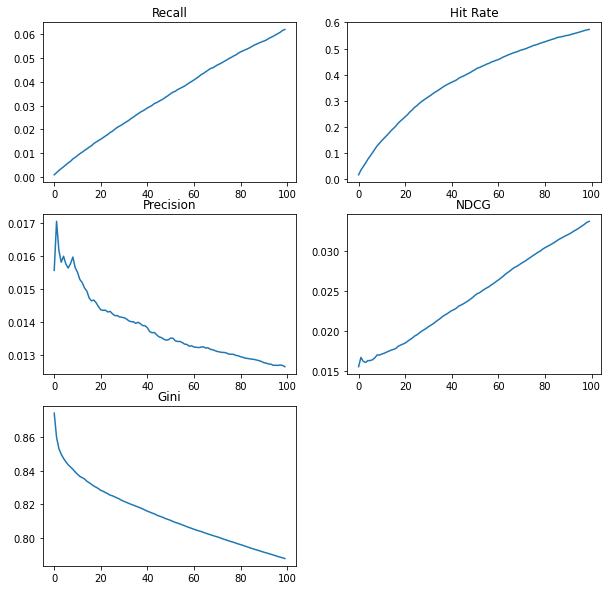

In [9]:
max_k = 100
user_history_length = torch.sum(test_env.current_user_history, 1).detach().cpu().numpy()
test_res_ = torch.stack(test_res).transpose(0,1).detach().cpu().numpy()
report = get_test_results(test_res_, user_history_length, test_gini_coefficient, max_k)

%matplotlib inline
recall = np.mean(report["recall"],0)
hit_rate = np.mean(report["hit_rate"],0)
precision = np.mean(report["precision"],0)
ndcg = np.mean(report["ndcg"],0)
gini_index = report["gini_index"]

plt.figure(figsize = (10,10))
plt.subplot(3,2,1)
plt.plot(recall)
plt.title("Recall")
plt.subplot(3,2,2)
plt.plot(np.arange(max_k), hit_rate)
plt.title("Hit Rate")
plt.subplot(3,2,3)
plt.plot(np.arange(max_k), precision)
plt.title("Precision")
plt.subplot(3,2,4)
plt.plot(np.arange(max_k), ndcg)
plt.title("NDCG")
plt.subplot(3,2,5)
plt.plot(np.arange(max_k), gini_index)
plt.title("Gini")
plt.show()